In [12]:
import os
import sys
from pathlib import Path

# Dynamically locate project root and set working dir
project_root = Path().resolve().parents[1]
os.chdir(project_root)
sys.path.append(str(project_root))

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from catboost import CatBoostRegressor, Pool
import optuna
from typing import Union, Dict, Tuple
from sklearn.model_selection import TimeSeriesSplit
from ydata_profiling import ProfileReport
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor as RF
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Table of Contents
- [Dataset Preparation](#Dataset-Preparation)
- [Baseline Model](#Baseline-Model)
- [Baseline Model with target lag features](#Baseline-Model-with-Target-Lag-Features)
- [Baseline Model with all lag features](#Baseline-Model-with-All-Lag-Features)
- [Gradient Boosting with Hyperparameters Tuning](#Gradient-Boosting-with-Hyperparameters-Tuning)
- [Conclusions](#Conclusions)

# Preprocessing

In [13]:
# Loading the data
data = pd.read_parquet('./data/raw_data/raw_data_full.parquet')

In [14]:
data.head(3)

,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01 00:00:00,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


Let's drop the columns that are not required for further analysis and modeling.

- 'yr' does not seem to help because it
- 'casual', 'registered' are already included in the target column 'cnt'

In [15]:
drop_cols = ['yr', 'casual', 'registered', 'datetime']

In [16]:
data = data.drop(columns=drop_cols)

In [17]:
data.head(3)

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32


# Baseline Model

We will use Random Forest using Raw Features as the Baseline Model because it does not require much tuning.

Then, we will add features and try other algorithms to see how big the improvement is.

For the metrics, we will use:
- MAPE
- MAE
- RMSE

In [29]:
def compute_metrics(
    y_true: Union[np.ndarray, list],
    y_pred: Union[np.ndarray, list]
) -> Dict[str, float]:
    """
    Compute evaluation metrics between true and predicted values.

    Metrics returned:
    - MAPE: Mean Absolute Percentage Error (in %)
    - MAE: Mean Absolute Error
    - RMSE: Root Mean Squared Error

    Parameters:
    ----------
    y_true : array-like
        Ground truth values.
    y_pred : array-like
        Predicted values.

    Returns:
    -------
    dict
        Dictionary with keys 'MAPE', 'MAE', and 'RMSE' and their float values.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 0.01, y_true))) * 100

    return {
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'MAPE': round(mape, 2)
    }

In [19]:
def prepare_dataset(
    df: pd.DataFrame,
    train_fraction: float = 0.8
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Splits a DataFrame into training and testing sets for features and target.

    Parameters:
    ----------
    df : pd.DataFrame
        The input DataFrame that must contain a 'target' column.
    train_fraction : float, optional (default=0.8)
        The fraction of data to use for training (between 0 and 1).

    Returns:
    -------
    x_train : pd.DataFrame
        Training features.
    x_test : pd.DataFrame
        Testing features.
    y_train : pd.Series
        Training target values.
    y_test : pd.Series
        Testing target values.
    """
    feats = [col for col in df.columns if col != 'target']
    x, y = df[feats], df['target']
    train_size = int(train_fraction * df.shape[0])
    x_train, x_test = x[:train_size], x[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return x_train, x_test, y_train, y_test

#### Target definition

For the target, we will use the next hour bike count because we want to predict what this value will be ti adjust the pricing.

## Training

In [20]:
df = data.copy()

In [21]:
df['target'] = df['cnt'].shift(-1).fillna(method='ffill')
df.drop(columns=['cnt'], inplace=True)

In [22]:
x_train, x_test, y_train, y_test = prepare_dataset(df, train_fraction=0.8)

In [23]:
%%time
model = RF(n_estimators=100)
model.fit(x_train, y_train)

CPU times: user 6.54 s, sys: 84 ms, total: 6.62 s
Wall time: 6.65 s


RandomForestRegressor()

## Inference

In [24]:
y_pred = model.predict(x_test)

## Postprocessing

In [30]:
metrics_base = compute_metrics(y_test.values, y_pred)
metrics_base

{'MAE': 85.33, 'RMSE': 15227.77, 'MAPE': np.float64(38.83)}

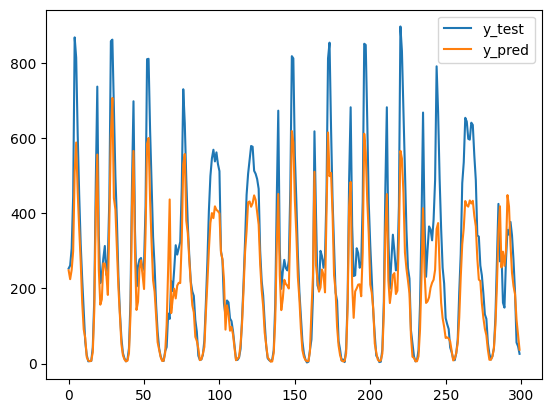

In [31]:
n = 300
plt.plot(y_test.values[:n], label='y_test')
plt.plot(y_pred[:n], label='y_pred')
plt.legend()

**Observations**

- We see that values below 200 are well predicted
- We see that the peaks are significantly underpredicted.

**Dummy model**

A dummy model is the model that tells that the next target value is the same as the previous value.

In [32]:
y_dummy = y_test.shift(1).fillna(method='bfill')
metrics_dummy = compute_metrics(y_test.values, y_dummy)

In [33]:
print('Dummy model scores:', metrics_dummy)
print('Baseline model scores:', metrics_base)

Dummy model scores: {'MAE': 85.15, 'RMSE': 16808.16, 'MAPE': np.float64(54.52)}
Baseline model scores: {'MAE': 85.33, 'RMSE': 15227.77, 'MAPE': np.float64(38.83)}


We see that our Baseline Model does not do much better that the dummy model

We see that only the MAPE metrics decreased quite well, while the other two are not, especially MAE.

This gives the conclusion that some feature engineering is definteily required.

# Baseline Model with Target Lag Features

A good idea is to add the lagged values of the target because we assume it's goona be available by the time we make the predictions for the next hour.

To understand how many lagged features we need, let's compute autocorrelation for the target.

In [34]:
# Let's compute autocorrelation
for lag in range(1, 25):
    print(f"Lag {lag}: {df['target'].autocorr(lag=lag):.3f}")

Lag 1: 0.844
Lag 2: 0.594
Lag 3: 0.404
Lag 4: 0.272
Lag 5: 0.146
Lag 6: 0.010
Lag 7: -0.093
Lag 8: -0.113
Lag 9: -0.058
Lag 10: -0.054
Lag 11: -0.107
Lag 12: -0.140
Lag 13: -0.114
Lag 14: -0.064
Lag 15: -0.060
Lag 16: -0.093
Lag 17: -0.063
Lag 18: 0.036
Lag 19: 0.156
Lag 20: 0.265
Lag 21: 0.373
Lag 22: 0.522
Lag 23: 0.710
Lag 24: 0.816


We see that the autocrrelations are high for the first and last 3 values that indicates a strong daily seasonality.

Let's add this lags.

When the model to be run in production, from the pipeline perspective, it's better to have the 'cnt' column back and take the lags relative to it to avoid confusion.

## Feature Engineering

In [35]:
df = data.copy()
df['target'] = df['cnt'].shift(-1).fillna(method='ffill')
df.head(3)

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,target
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,40.0
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,32.0
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,13.0


The 'cnt' column is alread 1 lag behind the target, so we need to make shifts of the 'cnt' column from 1 to 2 and from 22 to 23.

In [36]:
# Add first 2 lags
for i in range(1, 3):
    df[f'cnt_lag_{i}'] = df['cnt'].shift(i).fillna(method='bfill')

# Add last 2 lags
for i in range(22, 24):
    df[f'cnt_lag_{i}'] = df['cnt'].shift(i).fillna(method='bfill')

In [37]:
df.head(3)

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,target,cnt_lag_1,cnt_lag_2,cnt_lag_22,cnt_lag_23
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,40.0,16.0,16.0,16.0,16.0
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,32.0,16.0,16.0,16.0,16.0
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,13.0,40.0,16.0,16.0,16.0


## Training

Let's see if this helps the model

In [38]:
x_train, x_test, y_train, y_test = prepare_dataset(df, train_fraction=0.8)

In [39]:
x_train

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,cnt_lag_1,cnt_lag_2,cnt_lag_22,cnt_lag_23
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16,16.0,16.0,16.0,16.0
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40,16.0,16.0,16.0,16.0
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32,40.0,16.0,16.0,16.0
3,1,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13,32.0,40.0,16.0,16.0
4,1,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1,13.0,32.0,16.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13898,3,8,7,0,2,1,2,0.70,0.6667,0.74,0.1343,502,179.0,36.0,276.0,605.0
13899,3,8,8,0,2,1,2,0.70,0.6515,0.70,0.1642,705,502.0,179.0,213.0,276.0
13900,3,8,9,0,2,1,2,0.70,0.6667,0.74,0.1343,327,705.0,502.0,260.0,213.0
13901,3,8,10,0,2,1,2,0.74,0.6970,0.70,0.1343,250,327.0,705.0,285.0,260.0


In [40]:
model = RF(n_estimators=100)
model.fit(x_train, y_train)

RandomForestRegressor()

## Inference

In [41]:
y_pred = model.predict(x_test)

## Postprocessing

In [42]:
metrics_target_lag = compute_metrics(y_test.values, y_pred)
metrics_target_lag

{'MAE': 32.34, 'RMSE': 3019.01, 'MAPE': np.float64(22.64)}

In [43]:
print('Baseline model scores:', metrics_base)
print('Baseline model with target lags scores:', metrics_target_lag)

Baseline model scores: {'MAE': 85.33, 'RMSE': 15227.77, 'MAPE': np.float64(38.83)}
Baseline model with target lags scores: {'MAE': 32.34, 'RMSE': 3019.01, 'MAPE': np.float64(22.64)}


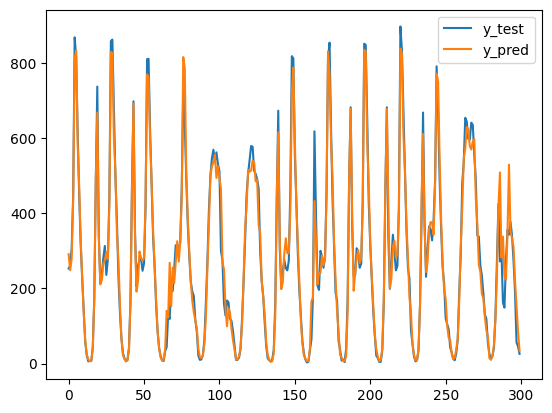

In [44]:
n = 300
plt.plot(y_test.values[:n], label='y_test')
plt.plot(y_pred[:n], label='y_pred')
plt.legend()

Now we see a significant imporvement.

We clearly see that the peaks now are better captured.

# Baseline Model with All Lag Features

Let's add the lag features for other features, not only for the target.

We will add only the first 3 lags, you can experiment with different lags and see the performance

In [45]:
df.columns

Index(['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt', 'target',
       'cnt_lag_1', 'cnt_lag_2', 'cnt_lag_22', 'cnt_lag_23'],
      dtype='object')

## Feature Engineering

In [46]:
lag_feats = ['hr', 'weekday', 'weathersit', 'temp', 'hum']

n = 3
for feat in lag_feats:
    for i in range(1, n+1):
        df[f'{feat}_lag_{i}'] = df[feat].shift(i).fillna(method='bfill')

## Training

In [47]:
x_train, x_test, y_train, y_test = prepare_dataset(df, train_fraction=0.8)

In [48]:
x_train.head(3)

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,weekday_lag_3,weathersit_lag_1,weathersit_lag_2,weathersit_lag_3,temp_lag_1,temp_lag_2,temp_lag_3,hum_lag_1,hum_lag_2,hum_lag_3
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,...,6.0,1.0,1.0,1.0,0.24,0.24,0.24,0.81,0.81,0.81
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,...,6.0,1.0,1.0,1.0,0.24,0.24,0.24,0.81,0.81,0.81
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,...,6.0,1.0,1.0,1.0,0.22,0.24,0.24,0.80,0.81,0.81


In [49]:
x_train.columns

Index(['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt', 'cnt_lag_1',
       'cnt_lag_2', 'cnt_lag_22', 'cnt_lag_23', 'hr_lag_1', 'hr_lag_2',
       'hr_lag_3', 'weekday_lag_1', 'weekday_lag_2', 'weekday_lag_3',
       'weathersit_lag_1', 'weathersit_lag_2', 'weathersit_lag_3',
       'temp_lag_1', 'temp_lag_2', 'temp_lag_3', 'hum_lag_1', 'hum_lag_2',
       'hum_lag_3'],
      dtype='object')

In [50]:
%%time
np.random.seed(23)
model = RF(n_estimators=100, verbose=1)
model.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   13.7s


CPU times: user 27.8 s, sys: 85.5 ms, total: 27.9 s
Wall time: 28.7 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   28.6s finished


RandomForestRegressor(verbose=1)

## Inference

In [51]:
y_pred = model.predict(x_test)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


# Postprocessing

In [52]:
metrics_all_lags = compute_metrics(y_test.values, y_pred)
metrics_all_lags

{'MAE': 32.3, 'RMSE': 3039.02, 'MAPE': np.float64(22.36)}

In [53]:
print('Baseline model scores:', metrics_base)
print('Baseline model with target lags scores:', metrics_target_lag)
print('Baseline model with all lags scores:', metrics_all_lags)

Baseline model scores: {'MAE': 85.33, 'RMSE': 15227.77, 'MAPE': np.float64(38.83)}
Baseline model with target lags scores: {'MAE': 32.34, 'RMSE': 3019.01, 'MAPE': np.float64(22.64)}
Baseline model with all lags scores: {'MAE': 32.3, 'RMSE': 3039.02, 'MAPE': np.float64(22.36)}


We see that adding the feature lags futher improved the performance, but the improvement is not that big as before.

However, with some basic feature engineering we still able to improve the scores and this we can add to the final production pipeline.

# Gradient Boosting with Hyperparameters Tuning

## Training

In [54]:
df.reset_index(drop=True, inplace=True)

In [55]:
x_train, x_test, y_train, y_test = prepare_dataset(df, train_fraction=0.8)

In [56]:
x_train

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,weekday_lag_3,weathersit_lag_1,weathersit_lag_2,weathersit_lag_3,temp_lag_1,temp_lag_2,temp_lag_3,hum_lag_1,hum_lag_2,hum_lag_3
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,...,6.0,1.0,1.0,1.0,0.24,0.24,0.24,0.81,0.81,0.81
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,...,6.0,1.0,1.0,1.0,0.24,0.24,0.24,0.81,0.81,0.81
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,...,6.0,1.0,1.0,1.0,0.22,0.24,0.24,0.80,0.81,0.81
3,1,1,3,0,6,0,1,0.24,0.2879,0.75,...,6.0,1.0,1.0,1.0,0.22,0.22,0.24,0.80,0.80,0.81
4,1,1,4,0,6,0,1,0.24,0.2879,0.75,...,6.0,1.0,1.0,1.0,0.24,0.22,0.22,0.75,0.80,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13898,3,8,7,0,2,1,2,0.70,0.6667,0.74,...,2.0,2.0,1.0,1.0,0.70,0.70,0.68,0.79,0.79,0.83
13899,3,8,8,0,2,1,2,0.70,0.6515,0.70,...,2.0,2.0,2.0,1.0,0.70,0.70,0.70,0.74,0.79,0.79
13900,3,8,9,0,2,1,2,0.70,0.6667,0.74,...,2.0,2.0,2.0,2.0,0.70,0.70,0.70,0.70,0.74,0.79
13901,3,8,10,0,2,1,2,0.74,0.6970,0.70,...,2.0,2.0,2.0,2.0,0.70,0.70,0.70,0.74,0.70,0.74


In [57]:
# Step 1: Define the Optuna objective with TimeSeriesSplit on x_train
def objective(trial):
    np.random.seed(42)
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "depth": trial.suggest_int("depth", 3, 8),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.5, 5),
        "iterations": 1000,
        "loss_function": "RMSE",
        "verbose": 0
    }

    train_idx = int(0.85 * x_train.shape[0])

    x_tr, x_val = x_train.iloc[:train_idx], x_train.iloc[train_idx:]
    y_tr, y_val = y_train.iloc[:train_idx], y_train.iloc[train_idx:]

    model = CatBoostRegressor(**params, random_seed=42)
    model.fit(x_tr, y_tr,
              eval_set=(x_val, y_val),
              early_stopping_rounds=100,
              use_best_model=True)

    preds = model.predict(x_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))

    # Save best iteration
    trial.set_user_attr("best_iteration", model.get_best_iteration())

    return rmse

In [58]:
# Step 2: Run the Optuna study
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=150)

# Step 4: Train final model on full x_train with best parameters
best_params = study.best_trial.params

[I 2025-12-12 13:13:17,375] A new study created in memory with name: no-name-23eed229-a40a-4533-9d43-f8b3780aadba
[I 2025-12-12 13:13:23,320] Trial 0 finished with value: 58.81042883240889 and parameters: {'learning_rate': 0.08116262258099886, 'depth': 8, 'l2_leaf_reg': 3.793972738151323}. Best is trial 0 with value: 58.81042883240889.
[I 2025-12-12 13:13:25,570] Trial 1 finished with value: 53.899954985643085 and parameters: {'learning_rate': 0.12374511199743694, 'depth': 3, 'l2_leaf_reg': 1.201975341512912}. Best is trial 1 with value: 53.899954985643085.
[I 2025-12-12 13:13:37,986] Trial 2 finished with value: 58.490011387089496 and parameters: {'learning_rate': 0.021035886311957897, 'depth': 8, 'l2_leaf_reg': 3.20501755284444}. Best is trial 1 with value: 53.899954985643085.
[I 2025-12-12 13:13:40,379] Trial 3 finished with value: 54.52022048390632 and parameters: {'learning_rate': 0.14453378978124864, 'depth': 3, 'l2_leaf_reg': 4.864594334728975}. Best is trial 1 with value: 53.89

In [59]:
best_trial = study.best_trial
print("Best RMSE:", best_trial.value)
print("Best iteration (trees):", best_trial.user_attrs["best_iteration"])

Best RMSE: 52.363896412172814
Best iteration (trees): 884


In [60]:
best_params.update({
    "iterations": best_trial.user_attrs["best_iteration"],
    "loss_function": "RMSE",
    "verbose": 0
})

In [61]:
final_model = CatBoostRegressor(**best_params)
final_model.fit(x_train, y_train)

## Inference

In [62]:
# Step 5: Predict on x_test and evaluate
y_pred = final_model.predict(x_test)

## Postprocessing

In [63]:
metrics_catbost = compute_metrics(y_test.values, y_pred)
metrics_catbost

{'MAE': 32.3, 'RMSE': 2523.6, 'MAPE': np.float64(25.56)}

In [64]:
print('Baseline model scores:', metrics_base)
print('Baseline model with target lags scores:', metrics_target_lag)
print('Baseline model with all lags scores:', metrics_all_lags)
print('Tuned Catboost:', metrics_catbost)

Baseline model scores: {'MAE': 85.33, 'RMSE': 15227.77, 'MAPE': np.float64(38.83)}
Baseline model with target lags scores: {'MAE': 32.34, 'RMSE': 3019.01, 'MAPE': np.float64(22.64)}
Baseline model with all lags scores: {'MAE': 32.3, 'RMSE': 3039.02, 'MAPE': np.float64(22.36)}
Tuned Catboost: {'MAE': 32.3, 'RMSE': 2523.6, 'MAPE': np.float64(25.56)}


In [65]:
best_params

{'learning_rate': 0.10122693396432887,
 'depth': 3,
 'l2_leaf_reg': 1.324874758318062,
 'iterations': 884,
 'loss_function': 'RMSE',
 'verbose': 0}

In [ ]:
# Save the model to experiments
final_model.save_model('./models/experiments/final_catboost_model.cbm')

- We see that we are able to reduce the RMSE score and MAE score quite well.
- MAPE score has not been reduced. However, since we have quite many values close to zero, MAPE is not a good metric in this case.
- Note that in Bayesian Optiization we optimized for RMSE, we can also try to optimize for MAE.

# Conclusions

- The Baseline Random Foreset model with no feature engineering gave almost the same result as the dummy model (last value shifted forward)
- Adding the target lags and feature lags improved the model significantly,
- Changing Random Forest to Catboost and tuning Catboost Hyperparameters with Bayesian Optimization helped futher improve the scores.
- For the production pipeline, we will use Catboost Model with Hyperparameter tuning.